In [30]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import time

In [31]:
df = pd.read_csv('3d_mapping_kalman.csv')
df = df.loc[df['Marker'] == 0]
df.head()

,Marker,x,y,z,t (s),Frame
4,0.0,-0.621456,-1.284723,2.542341,0.033333,2.0
9,0.0,-0.621456,-1.284723,2.542341,0.066667,3.0
14,0.0,-0.621456,-1.284723,2.542341,0.100000,4.0
19,0.0,-0.622418,-1.286914,2.546301,0.133333,5.0
24,0.0,-0.622418,-1.286914,2.546301,0.166667,6.0


In [44]:
# Add velocity block
v = df[['t (s)','x','y', 'z']]
v['v (x)'] = df['x'].diff()/df['t (s)'].diff()
v['v (y)'] = df['y'].diff()/df['t (s)'].diff()
v['v (z)'] = df['z'].diff()/df['t (s)'].diff()
v = v.fillna(0)
v.head()

C:\Users\Darin Tsui\AppData\Local\Temp\ipykernel_4604\2808463410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['v (x)'] = df['x'].diff()/df['t (s)'].diff()


,t (s),x,y,z,v (x),v (y),v (z)
4,0.033333,-0.621456,-1.284723,2.542341,0.000000,0.00000,0.000000
9,0.066667,-0.621456,-1.284723,2.542341,0.000000,0.00000,0.000000
14,0.100000,-0.621456,-1.284723,2.542341,0.000000,0.00000,0.000000
19,0.133333,-0.622418,-1.286914,2.546301,-0.028838,-0.06574,0.118802
24,0.166667,-0.622418,-1.286914,2.546301,0.000000,0.00000,0.000000


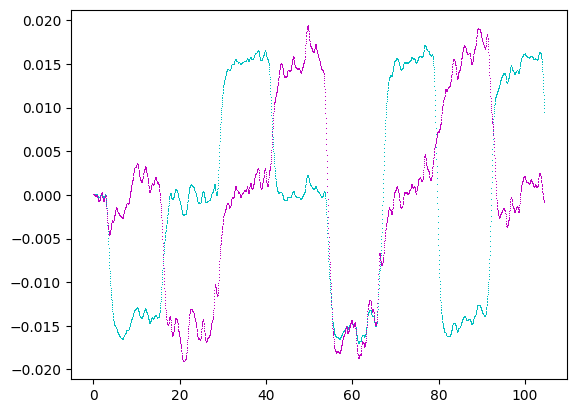

In [45]:
# Use Mean Aveage Filter

smoothing_factor = 0.3
EMA_03_x = v.loc[:, ['v (x)']].ewm(alpha=0.1, adjust=False).mean()
EMA_03_y = v.loc[:, ['v (y)']].ewm(alpha=0.1, adjust=False).mean()
EMA_03_z = v.loc[:, ['v (z)']].ewm(alpha=0.1, adjust=False).mean()
EMA_03_x = EMA_03_x.ewm(alpha=0.1, adjust=False).mean()
EMA_03_y = EMA_03_y.ewm(alpha=0.1, adjust=False).mean()
EMA_03_z = EMA_03_z.ewm(alpha=0.1, adjust=False).mean()
EMA_03_x = EMA_03_x.ewm(alpha=0.1, adjust=False).mean()
EMA_03_y = EMA_03_y.ewm(alpha=0.1, adjust=False).mean()
EMA_03_z = EMA_03_z.ewm(alpha=0.1, adjust=False).mean()
EMA_03_x = EMA_03_x.ewm(alpha=0.1, adjust=False).mean()
EMA_03_y = EMA_03_y.ewm(alpha=0.1, adjust=False).mean()
EMA_03_z = EMA_03_z.ewm(alpha=0.1, adjust=False).mean()

plt.plot(v.loc[:, ['t (s)']], EMA_03_x, 'c,')
plt.plot(v.loc[:, ['t (s)']], EMA_03_y, 'm,')
#plt.ylim([-4, 4])

In [25]:
# Import Measurements and the Initial State
measurements = np.column_stack((df['x'], df['y'], df['z'], v['v (x)'],  v['v (y)'],  v['v (z)']))

# In matrix form - x = [x, y, z, x', y', z', x", y", z"]
initial_state_mean = [measurements[0, 0], measurements[0, 1], v['v (x)'], v['v (y)'], 0]

# Assumption: No jerk
# Matrix: [x y z x' y' z' x" y" z"]
# Eqns: 
#x(k) = x(k-1) + x'(k-1)dt + 1/2x"(k-1)*dt^2; [1 0 0 1 0 0 0.5 0   0  ]
#y(k) = y(k-1) + y'(k-1)dt + 1/2y"(k-1)*dt^2; [0 1 0 0 1 0 0   0.5 0  ]
#z(k) = z(k-1) + z'(k-1)dt + 1/2z"(k-1)*dt^2; [0 0 1 0 0 1 0   0   0.5]
#x'(k) = x'(k-1) + x"(k-1)dt;                 [0 0 0 1 0 0 1   0   0  ]
#y'(k) = y'(k-1) + y"(k-1)dt;                 [0 0 0 0 1 0 0   1   0  ]
#z'(k) = z'(k-1) + z"(k-1)dt;                 [0 0 0 0 0 1 0   0   1  ]
#x"(k) = x"(k-1);                             [0 0 0 0 0 0 1   0   0  ]
#y"(k) = y"(k-1);                             [0 0 0 0 0 0 0   1   0  ]
#z"(k) = z"(k-1);                             [0 0 0 0 0 0 0   0   1  ]

transition_matrix = [[1, 0, 0, 1, 0, 0, 0.5, 0, 0],
                     [0, 1, 0, 0, 1, 0, 0, 0.5, 0],
                     [0, 0, 1, 0, 0, 1, 0, 0, 0.5],
                     [0, 0, 0, 1, 0, 0, 1, 0, 0]
                     [0, 0, 0, 0, 1, 0, 0, 1, 0]
                     [0, 0, 0, 0, 0, 1, 0, 0, 1]
                     [0, 0, 0, 0, 0, 0, 1, 0, 0]
                     [0, 0, 0, 0, 0, 0, 0, 1, 0]
                     [0, 0, 0, 0, 0, 0, 0, 0, 1]]

# We only observe x and y and z and their velocities
observation_matrix = [[1, 0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 1, 0, 0, 0, 0]
                      [0, 0, 1, 0, 0, 1, 0, 0, 0]]

In [26]:
kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
smoothed_state_means, smoothed_state_covariances = kf1.smooth(measurements)

# Build Kalman filter, With 10x covariance showing we have less confidence in our measurements than our dynamics
kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 10*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf1 = kf1.em(measurements, n_iter=5)
smoothed_state_means, smoothed_state_covariances = kf1.smooth(measurements)

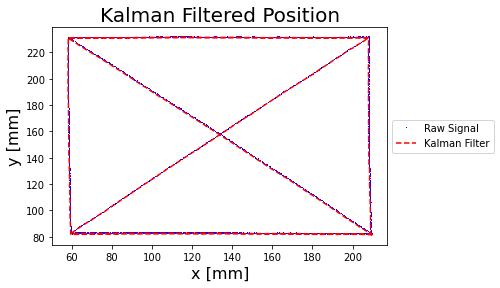

In [27]:
# Plot Kalman Filter
plt.plot(df['x'], df['y'], 'b,', label='Raw Signal')
plt.plot(smoothed_state_means[:, 0], smoothed_state_means[:, 1], 'r--', label='Kalman Filter')

plt.title('Kalman Filtered Position', fontsize=20)
plt.xlabel('x [mm]', fontsize=16)
plt.ylabel('y [mm]', fontsize=16)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

In [79]:
# Implement Kalman Filter In Real Time

# Time to Build Filter
time_before = time.time()
initial = 20

kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 10*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf2 = kf2.em(measurements[0:initial, :], n_iter=5)
filtered_state_means, filtered_state_covariances = kf2.filter(measurements[:initial,:])

print("Time to build and train kf2: %s seconds" % (time.time() - time_before))

# Time to Get New Points
time_before = time.time()

now = filtered_state_means[-1, :]
P_now = filtered_state_covariances[-1, :]
new = np.zeros(4)
i = 0

for measurement in measurements[initial:, :]:
    now, P_now = kf2.filter_update(filtered_state_mean = now,
                                       filtered_state_covariance = P_now,
                                       observation = measurement)
    new = np.vstack([new, now])
    i = i + 1

new = new[1:]
print("Time to update kf2: %s seconds" % (time.time() - time_before))

Time to build and train kf2: 0.005983591079711914 seconds
Time to update kf2: 1.5967297554016113 seconds


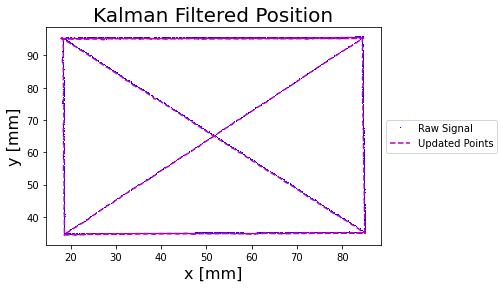

In [80]:
# Plot Kalman Filter
plt.plot(df['x'], df['y'], 'b,', label='Raw Signal')
#plt.plot(filtered_state_means[:, 0], filtered_state_means[:, 2], 'r-', label='Initialized Points')
plt.plot(new[:, 0], new[:, 2], 'm--', label='Updated Points')

plt.title('Kalman Filtered Position', fontsize=20)
plt.xlabel('x [mm]', fontsize=16)
plt.ylabel('y [mm]', fontsize=16)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')